# Clean Clusters

In [1]:
import pandas as pd
import numpy as np
import concurrent.futures as cf
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import nltk
import pickle
from glob import glob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import altair as alt
from scipy import stats

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
path_in = '/Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/'
models = path_in + 'models/kmeans/'

In [3]:
df = pd.read_csv('km_titles_500and1000k_clusters_tf.csv', parse_dates=['JobDate'], low_memory=False)

df.head()

,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles,titles_uni_1000,dist_uni_1000,titles_bi_1000,dist__bi_1000,titles_tri_1000,dist_tri_1000,titles_uni_500,dist_uni_500,titles_bi_500,dist__bi_500,titles_tri_500,dist_tri_500
0,en,McLean,VA,Public Sector Sap Training Lead,2012-07-05,United States US home Careers home Campus Int...,129092937,38.9498,-77.2278,22103.0,Fairfax,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,PricewaterhouseCoopers,NaN,15-119900,NaN,0,Company,Finance: General Accounting;Specialized Skills...,{'Accounting': 'Finance: General Accounting;Sp...,False,Bachelor of Science,Bachelor of Science|Bachelor's,NaN,6.0,541219.0,15-1199.00,NaN,NaN,NaN,NaN,NaN,NaN,6+,high,16,Public Sector Sap Training Lead,NaN,16.0,Technical Consultant / Analyst,6-10 years,2012,United States US home Careers home Campus Int...,8209,united states us home careers home campus int...,"['United', 'States', 'US', 'home', 'Careers', ...","['Public', 'Sector', 'Sap', 'Training', 'Lead']",1175,united states us home careers home campus inte...,public sector sap training lead,97,2823.18437,177,3820.23588,1,2753.93940,272,1372.86216,10,1828.74446,1,1351.37864
1,en,Cary,NC,Maintenance Supervisor,2017-11-12,"Maintenance Supervisor\n\nCary, North Carolina...",38298165295,35.7585,-78.7783,27511.0,Wake,NaN,MT373958,39580: Metropolitan Statistical Area,Real Estate,Maintenance Supervisor,49101100,NaN,0,Job Board,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,General Equivalency Degree,NaN,2.0,5312.0,49-1011.00,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,12,Maintenance Supervisor,12.0,12.0,Maintenance Supervisor,Minimum of 2-3 years,2017,"Maintenance Supervisor Cary, North Carolina - ...",1517,"maintenance supervisor cary, north carolina - ...","['Maintenance', 'Supervisor', 'Cary,', 'North'...","['Maintenance', 'Supervisor']",217,maintenance supervisor cary north carolina usd...,maintenance supervisor,244,2206.16376,724,2886.20519,1,2071.98409,63,1055.97205,354,1339.85008,1,1000.42263
2,en,Seattle,WA,Junior Network Engineer,2016-01-30,Jr. Network Engineer Insight Global Seattle...,38014986781,47.7593,-122.2520,98028.0,King,42644.0,DV534264|MT534266,42660: Metropolitan Statistical Area|500: Comb...,Recruiting Agency,Junior Network Engineer,15114300,Insight Global Incorporated,0,Job intermediary,Information Technology: General Networking;Spe...,{'Cisco': 'Information Technology: General Net...,False,NaN,NaN,NaN,NaN,54.0,15-1199.02,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Junior Network Engineer,NaN,NaN,Network Engineer / Architect,NaN,2016,Jr. Network Engineer Insight Global Seattle...,1895,jr. network engineer insight global seattle...,"['Jr.', 'Network', 'Engineer', 'Insight', 'Glo...","['Junior', 'Network', 'Engineer']",280,jr network engineer insight global seattle wa ...,junior network engineer,8,2422.87004,368,3217.74877,1,2331.28296,222,1166.78669,29,1516.74451,1,1134.71146
3,en,Concord,CA,Loss Prevention Associate,2012-08-22,Current Job Stats 154 New Jobs Posted Today 2...,142560438,37.9834,-122.0370,94520.0,Contra Costa,36084.0,DV063608|MT064186,41860: Metropolitan Statistical Area|488: Comb...,Sears,Loss Prevention Associate,11-919908,NaN,0,Company from Job Board,Pu

In [4]:
df.shape

(100000, 64)

In [5]:
%%time

df = df[['CleanJobTitle', 'JobID', 'JobDate', 'JobText', 'BGTOcc', 'titles_uni_1000', 'dist_uni_1000', 'titles_bi_1000', 'dist__bi_1000', 'titles_tri_1000','dist_tri_1000', 'titles_uni_500', 'dist_uni_500', 'titles_bi_500', 'dist__bi_500', 'titles_tri_500', 'dist_tri_500']].copy()

CPU times: user 83.6 ms, sys: 243 ms, total: 327 ms
Wall time: 377 ms


In [6]:
df.shape

(100000, 17)

In [9]:
pd.options.display.float_format = '{:.4f}'.format

df.describe().T

,count,mean,std,min,25%,50%,75%,max
JobID,100000.0000,23052570541.1474,18598488432.9785,2374.0000,290965267.7500,37939915177.5000,38345041766.2500,38824145679.0000
titles_uni_1000,100000.0000,337.4052,296.4834,0.0000,72.0000,250.0000,564.0000,999.0000
dist_uni_1000,100000.0000,2539.9137,393.7886,1670.1852,2217.6335,2431.8853,2646.8200,11004.8532
titles_bi_1000,100000.0000,330.5419,294.9977,0.0000,54.0000,271.0000,564.0000,999.0000
dist__bi_1000,100000.0000,3388.1350,561.8005,2260.0476,2896.4479,3232.2696,3549.3960,13613.1089
titles_tri_1000,100000.0000,52.4821,165.9049,0.0000,1.0000,1.0000,1.0000,999.0000
dist_tri_1000,100000.0000,2449.7954,363.5514,2071.9841,2071.9841,2331.2830,2553.8563,7471.5712
titles_uni_500,100000.0000,167.4505,148.3684,0.0000,32.0000,134.0000,281.0000,499.0000
dist_uni_500,100000.0000,1227.3545,201.7545,774.0697,1061.3837,1172.3948,1283.0001,5483.4895
titles_bi_500,100000.0000,166.9602,155.1084,0.0000,10.0000,130.0000,305.0000,499.0000


In [10]:
df.columns

Index(['CleanJobTitle', 'JobID', 'JobDate', 'JobText', 'BGTOcc',
       'titles_uni_1000', 'dist_uni_1000', 'titles_bi_1000', 'dist__bi_1000',
       'titles_tri_1000', 'dist_tri_1000', 'titles_uni_500', 'dist_uni_500',
       'titles_bi_500', 'dist__bi_500', 'titles_tri_500', 'dist_tri_500'],
      dtype='object')

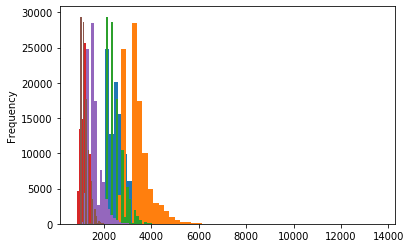

In [5]:
for i in df.columns:
    if 'dist' in i:
        df[i].plot(kind='hist', bins=50)

In [6]:
df['dist_uni_1000'].describe()

count    100000.000000
mean       2539.913696
std         393.788612
min        1670.185200
25%        2217.633530
50%        2431.885330
75%        2646.819950
max       11004.853240
Name: dist_uni_1000, dtype: float64

In [16]:
np.percentile(df['dist_uni_1000'], 10)

2186.3941

In [31]:
df.loc[df['dist_uni_1000'] < np.percentile(df['dist_uni_1000'], 5), 'dist_uni_1000'].count()

4999

In [25]:
testing = df.loc[df['dist_uni_1000'] < np.percentile(df['dist_uni_1000'], 5), ['titles_uni_1000', 'dist_uni_1000']]

testing.groupby('titles_uni_1000')['titles_uni_1000'].count().describe()

count    191.0000
mean      26.1728
std       85.9030
min        1.0000
25%        2.5000
50%        8.0000
75%       22.0000
max     1114.0000
Name: titles_uni_1000, dtype: float64

In [26]:
testing = df.loc[df['dist_uni_1000'] < np.percentile(df['dist_uni_1000'], 10), ['titles_uni_1000', 'dist_uni_1000']]

testing.groupby('titles_uni_1000')['titles_uni_1000'].count().describe()

count    294.0000
mean      33.9660
std       88.8304
min        1.0000
25%        4.0000
50%       11.0000
75%       26.0000
max     1114.0000
Name: titles_uni_1000, dtype: float64

In [29]:
testing = df.loc[df['dist_uni_1000'] < np.percentile(df['dist_uni_1000'], 10), ['titles_uni_1000', 'dist_uni_1000']]

np.where(x < np.percentile(df['dist_uni_1000'], 5), 1, 0)

(9986, 2)

In [30]:
df['dist_uni_1000'].apply(lambda x: np.where(x < np.percentile(df['dist_uni_1000'], 5), 1, 0)).head()

0    0
1    0
2    0
3    0
4    0
Name: dist_uni_1000, dtype: int64

In [34]:
np.where(df['dist_uni_1000'] < np.percentile(df['dist_uni_1000'], 5), 1, 0).sum()

4999

In [7]:
for i in df.columns:
    if 'dist' in i:
        df[i + '_dummy'] = np.where(df[i] < np.percentile(df[i], 5), 1, 0)

df.head()

,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles,titles_uni_1000,dist_uni_1000,titles_bi_1000,dist__bi_1000,titles_tri_1000,dist_tri_1000,titles_uni_500,dist_uni_500,titles_bi_500,dist__bi_500,titles_tri_500,dist_tri_500,dist_uni_1000_dummy,dist__bi_1000_dummy,dist_tri_1000_dummy,dist_uni_500_dummy,dist__bi_500_dummy,dist_tri_500_dummy
0,en,McLean,VA,Public Sector Sap Training Lead,2012-07-05,United States US home Careers home Campus Int...,129092937,38.9498,-77.2278,22103.0,Fairfax,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,PricewaterhouseCoopers,NaN,15-119900,NaN,0,Company,Finance: General Accounting;Specialized Skills...,{'Accounting': 'Finance: General Accounting;Sp...,False,Bachelor of Science,Bachelor of Science|Bachelor's,NaN,6.0,541219.0,15-1199.00,NaN,NaN,NaN,NaN,NaN,NaN,6+,high,16,Public Sector Sap Training Lead,NaN,16.0,Technical Consultant / Analyst,6-10 years,2012,United States US home Careers home Campus Int...,8209,united states us home careers home campus int...,"['United', 'States', 'US', 'home', 'Careers', ...","['Public', 'Sector', 'Sap', 'Training', 'Lead']",1175,united states us home careers home campus inte...,public sector sap training lead,97,2823.18437,177,3820.23588,1,2753.93940,272,1372.86216,10,1828.74446,1,1351.37864,0,0,0,0,0,0
1,en,Cary,NC,Maintenance Supervisor,2017-11-12,"Maintenance Supervisor\n\nCary, North Carolina...",38298165295,35.7585,-78.7783,27511.0,Wake,NaN,MT373958,39580: Metropolitan Statistical Area,Real Estate,Maintenance Supervisor,49101100,NaN,0,Job Board,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,General Equivalency Degree,NaN,2.0,5312.0,49-1011.00,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,12,Maintenance Supervisor,12.0,12.0,Maintenance Supervisor,Minimum of 2-3 years,2017,"Maintenance Supervisor Cary, North Carolina - ...",1517,"maintenance supervisor cary, north carolina - ...","['Maintenance', 'Supervisor', 'Cary,', 'North'...","['Maintenance', 'Supervisor']",217,maintenance supervisor cary north carolina usd...,maintenance supervisor,244,2206.16376,724,2886.20519,1,2071.98409,63,1055.97205,354,1339.85008,1,1000.42263,0,0,0,0,0,0
2,en,Seattle,WA,Junior Network Engineer,2016-01-30,Jr. Network Engineer Insight Global Seattle...,38014986781,47.7593,-122.2520,98028.0,King,42644.0,DV534264|MT534266,42660: Metropolitan Statistical Area|500: Comb...,Recruiting Agency,Junior Network Engineer,15114300,Insight Global Incorporated,0,Job intermediary,Information Technology: General Networking;Spe...,{'Cisco': 'Information Technology: General Net...,False,NaN,NaN,NaN,NaN,54.0,15-1199.02,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Junior Network Engineer,NaN,NaN,Network Engineer / Architect,NaN,2016,Jr. Network Engineer Insight Global Seattle...,1895,jr. network engineer insight global seattle...,"['Jr.', 'Network', 'Engineer', 'Insight', 'Glo...","['Junior', 'Network', 'Engineer']",280,jr network engineer insight global seattle wa ...,junior network engineer,8,2422.87004,368,3217.74877,1,2331.28296,222,1166.78669,29,1516.74451,1,1134.71146,0,0,0,0,0,0
3,en,Concord,CA,Loss Prevention Associate,2012-08-22,Current Job Stats 154 New Jobs Posted Today 2...,142560438,37.9834,-122.0370,94520.0,Contra Co

In [8]:
df.shape

(100000, 70)

In [38]:
(df.drop(['dist_uni_1000', 'dist__bi_1000', 'dist_tri_1000',
         'dist_uni_500', 'dist__bi_500', 'dist_tri_500'], axis=1)
   .to_csv(path_in + 'km_titles_500and1000k_clusters_tf.csv', index=False))

In [41]:
df.drop(['dist_uni_1000', 'dist__bi_1000', 'dist_tri_1000',
         'dist_uni_500', 'dist__bi_500', 'dist_tri_500'], axis=1).shape

(100000, 17)

In [9]:
%%time

df.to_csv(path_in + 'full_dataset_titles_500and1000k_tf.csv', index=False)

CPU times: user 41 s, sys: 3.42 s, total: 44.4 s
Wall time: 46 s


In [11]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 70 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Language                          100000 non-null  object        
 1   CanonCity                         98709 non-null   object        
 2   CanonState                        99992 non-null   object        
 3   CleanJobTitle                     100000 non-null  object        
 4   JobDate                           100000 non-null  datetime64[ns]
 5   JobText                           100000 non-null  object        
 6   JobID                             100000 non-null  int64         
 7   Latitude                          98710 non-null   float64       
 8   Longitude                         98710 non-null   float64       
 9   CanonPostalCode                   98466 non-null   float64       
 10  CanonCounty                      